In [1]:
!pip install datasets
!pip install transformers
!pip install pysentimiento

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from pysentimiento import create_analyzer
import pandas as pd
import numpy as np
import operator
import sklearn.metrics as metrics
import torch
import random
from collections import defaultdict
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import string
import re
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Misogynous','Not Misogynous'], yticklabels=['Misogynous', 'Not Misogynous'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def evaluate_model(df):
    y_true = df['misogynous']
    y_pred = df['predictions']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score_macro": macro_f1,
        "confusion_matrix": conf_matrix
    }

In [4]:
sentiment_analyzer = create_analyzer("sentiment", lang="es")
def analyze_sentiment(text):
    result = sentiment_analyzer.predict(text.lower())
    return result.output

def error_analysis_sentiment(df):
    false_positives = df[(df['predictions'] == 1) & (df['misogynous'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['misogynous'] == 1)]

    sentiment_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        sentiment = analyze_sentiment(text)
        sentiment_counts['FP'][sentiment] += 1

    for text in (false_negatives['text']):
        sentiment = analyze_sentiment(text)
        sentiment_counts['FN'][sentiment] += 1

    return sentiment_counts

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [5]:
irony_analyzer = create_analyzer("irony", lang="es")
def analyze_irony(text):
    result = irony_analyzer.predict(text.lower())
    return result.output

def error_analysis_irony(df):
    false_positives = df[(df['predictions'] == 1) & (df['misogynous'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['misogynous'] == 1)]

    irony_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        irony = analyze_irony(text)
        irony_counts['FP'][irony] += 1

    for text in (false_negatives['text']):
        irony = analyze_irony(text)
        irony_counts['FN'][irony] += 1

    return irony_counts

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [6]:
emotion_analyzer = create_analyzer("emotion", lang="es")
def analyze_emotion(text):
    result = emotion_analyzer.predict(text.lower())
    return result.output

def error_analysis_emotion(df):
    false_positives = df[(df['predictions'] == 1) & (df['misogynous'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['misogynous'] == 1)]

    emotion_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        emotion = analyze_emotion(text)
        emotion_counts['FP'][emotion] += 1

    for text in (false_negatives['text']):
        emotion = analyze_emotion(text)
        emotion_counts['FN'][emotion] += 1

    return emotion_counts

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [7]:
pos_analyzer = create_analyzer("pos", lang="es")
def analyze_pos(text):
    result = pos_analyzer.predict(text.lower())
    return result.labels

def error_analysis_pos(df):
    false_positives = df[(df['predictions'] == 1) & (df['misogynous'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['misogynous'] == 1)]

    pos_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        pos_tags = analyze_pos(text)
        for pos in pos_tags:
            pos_counts['FP'][pos] += 1

    for text in (false_negatives['text']):
        pos_tags = analyze_pos(text)
        for pos in pos_tags:
            pos_counts['FN'][pos] += 1

    return pos_counts

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [8]:
ner_analyzer = create_analyzer("ner", lang="es")
def analyze_ner(text):
    result = ner_analyzer.predict(text.lower())
    return result.labels

def error_analysis_ner(df):
    false_positives = df[(df['predictions'] == 1) & (df['misogynous'] == 0)]
    false_negatives = df[(df['predictions'] == 0) & (df['misogynous'] == 1)]

    ner_counts = {'FP': defaultdict(int), 'FN': defaultdict(int)}

    for text in (false_positives['text']):
        ner_tags = analyze_ner(text)
        for ner in ner_tags:
            ner_counts['FP'][ner] += 1

    for text in (false_negatives['text']):
        ner_tags = analyze_ner(text)
        for ner in ner_tags:
            ner_counts['FN'][ner] += 1

    return ner_counts

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def plot_wordcloud(texts, title):
    stop_words = set(stopwords.words('spanish') + list(string.punctuation) + ['http', 'https', 't.co'])

    words = word_tokenize(" ".join(texts).lower())

    words_filtered = [word for word in words if word not in stop_words]
    word_freq = Counter(words_filtered)
    print("Las 25 palabras más comunes y su núm de apariciones:")
    print(word_freq.most_common(25))

    words_filtered = re.compile(
        r"((?<=[^a-zA-Z0-9])(?:https?\:\/\/|[a-zA-Z0-9]{1,}\.{1}|\b)(?:\w{1,}\.{1}){1,5}(?:com|co|org|edu|gov|uk|net|ca|de|jp|fr|au|us|ru|ch|it|nl|se|no|es|mil|iq|io|ac|ly|sm){1}(?:\/[a-zA-Z0-9]{1,})*)"
    ).sub("", " ".join(words_filtered))


    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(words_filtered)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [10]:
from transformers import AutoTokenizer
from collections import Counter
import numpy as np

def vocab_coverage(texts, model_name, verbose=True):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    total_tokens = []
    oov_tokens = []

    for text in texts:
        tokens = tokenizer.tokenize(text.lower())
        total_tokens.extend(tokens)

        for token in tokens:
            if tokenizer.convert_tokens_to_ids(token) == tokenizer.unk_token_id:
                oov_tokens.append(token)

    total_count = len(total_tokens)
    oov_count = len(oov_tokens)
    coverage = 100 * (1 - oov_count / total_count) if total_count > 0 else 0

    if verbose:
        print(f"Modelo: {model_name}")
        print(f"Tokens totales: {total_count}")
        print(f"Tokens OOV: {oov_count}")
        print(f"Coverage del vocabulario: {coverage:.2f}%")
        print(f"Top 10 OOV tokens más frecuentes: {Counter(oov_tokens).most_common(10)}")

    return {
        'model': model_name,
        'coverage': coverage,
        'total_tokens': total_count,
        'oov_tokens': oov_count,
        'top_oov': Counter(oov_tokens).most_common(20)
    }


In [11]:
import pandas as pd

df_test = pd.read_csv("ibereval_misogyny2018_es_test.csv", delimiter=",", names=['_', 'id', 'text', 'misogynous', 'misogyny_category', 'target'], header=0)

df_few_shot = pd.read_csv("predicciones_few_shot_ibereval_test_lower_preprocess_without_hashtags_and_emojis_and_url.csv", delimiter=",", header=None, names=['predictions'])
df_robertuito = pd.read_csv("predictions_test_robertuito.csv", delimiter=",")
df_roberta = pd.read_csv("predictions_test_roberta.csv", delimiter=",")

print(df_test.head())
print(df_few_shot.head())
print(df_robertuito.head())
print(df_roberta.head())


assert len(df_test) == len(df_few_shot), "El número de predicciones no coincide con el número de textos en el CSV"
assert len(df_test) == len(df_robertuito), "El número de predicciones no coincide con el número de textos en el CSV"
assert len(df_test) == len(df_roberta), "El número de predicciones no coincide con el número de textos en el CSV"




   _    id                                               text  misogynous  \
0  0  3400  Luego en marzo que Adán saque la bufanda rosa ...           1   
1  1  3401  @reginabisex Unmnmnn imagino q tú eres así ó m...           1   
2  2  3402  @laSextaTV Tú eres un HDLGP, vosotros sí que s...           0   
3  3  3403  @Manaka_msyra @BrianD_Campbell callate zorra m...           1   
4  4  3404     @Eli_la_faldas Yo tengo una con forma de polla           0   

  misogyny_category  target  
0         discredit  active  
1         discredit  active  
2                 0       0  
3         dominance  active  
4                 0       0  
   predictions
0            1
1            1
2            0
3            1
4            0
   predictions
0            1
1            1
2            0
3            1
4            1
   predictions
0            1
1            1
2            0
3            1
4            1


-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para few_shot:
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       416
           1       0.89      0.88      0.89       415

    accuracy                           0.89       831
   macro avg       0.89      0.89      0.89       831
weighted avg       0.89      0.89      0.89       831

Accuracy: 0.8893
Precision: 0.8929
Recall: 0.8843
Macro F1 Score: 0.8893


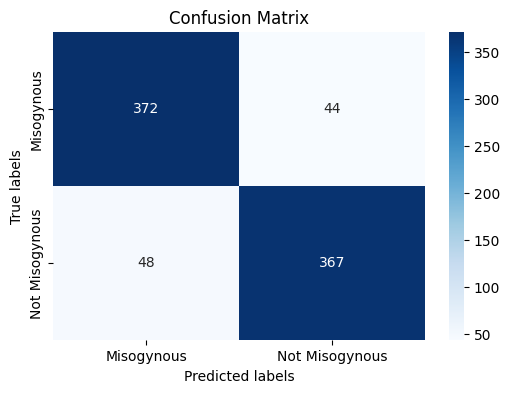

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
NEG: 37
NEU: 4
POS: 3
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 35
NEU: 7
POS: 6
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
not ironic: 34
ironic: 10
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 40
ironic: 8
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
anger: 31
others: 13
-----------------------------------
Emociones en Falsos Negativos:
anger: 30
others: 13
joy: 5
-----------------------------------
-----------------------------------

Análisis de POS (Parts of Speech):

POS en Falsos Positivos:
USER: 23
ADV: 55
VERB: 192
DET: 136
INTJ: 18
NOUN: 234
CONJ: 37
ADJ: 63
PUNCT: 124
PRON: 95
ADP: 122
SCONJ: 53
PART: 2
AUX: 22
PROPN: 3
NUM

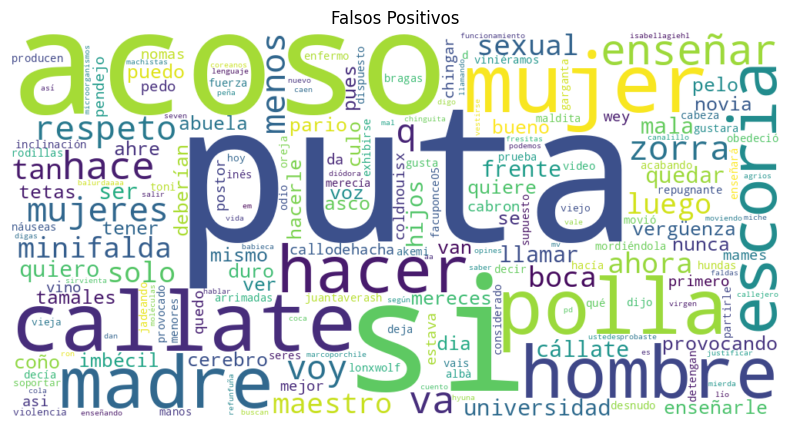

-----------------------------------
Falsos Negativos:
Las 25 palabras más comunes y su núm de apariciones:
[('puta', 31), ('cállate', 13), ('si', 11), ('mierda', 8), ('polla', 7), ('q', 7), ('escoria', 6), ('mujer', 6), ('axel', 6), ('...', 5), ('vos', 5), ('hija', 5), ('callate', 5), ('madre', 4), ('gusta', 4), ('d', 4), ('ama', 4), ('enseñar', 4), ('boca', 4), ('hijo', 3), ('ir', 3), ('mereces', 3), ('chica', 3), ('así', 3), ('bien', 3)]


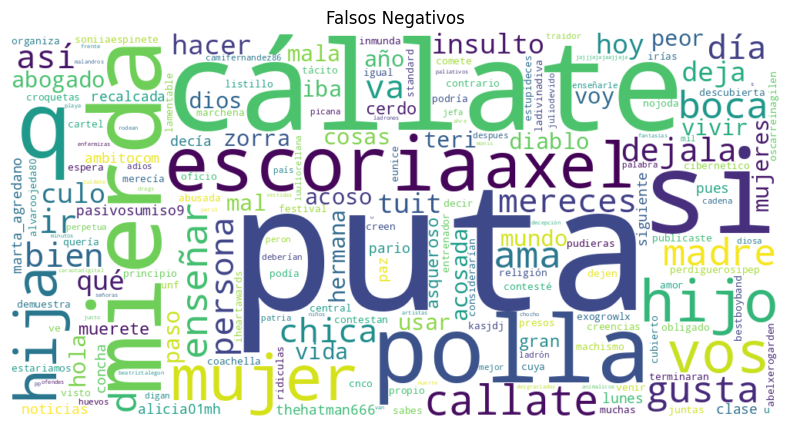

-----------------------------------
-----------------------------------

Ejemplos de Falsos Positivos:

@coldnouisx primero era un callate luego vino el callate la boca y ahora ya es un callate la puta boca❤️
@callodehacha Y este pendejo!!! Wey tu eres un puta que se da al mejor postor. Por lo menos el estava pedo, pero tu cabron no mames. A chingar tu madre asi nomas quedo!!!
@juantaverash El acoso en la mujer es tan solo cuando el hombre no le gusta, si el hombre le gustara, no fuera acoso!!!
“El maestro decía que viniéramos en minifalda y sin bragas” el acoso sexual que hacía un maestro en la universidad https://t.co/tWUS1scaYf https://t.co/wJYlI3qvu4
Toni Albà, de exhibirse desnudo frente a menores a llamar 'mala puta' a Inés Arrimadas. ¿Qué enseñará este enfermo a sus hijos? https://t.co/xqQ4jRXSyQ
Y tú eres una maldita escoria con una repugnante inclinación por los hombres.. ¡Seres como tú me producen náuseas! https://t.co/TaHDcpZdnm
@FacuPonce05 cállate y deja d decir puta
@Lonx

In [12]:
df_test["predictions"] = df_few_shot["predictions"]
model_name = "few_shot"
print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")




print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text']):
    print(i)





Modelo: PlanTL-GOB-ES/roberta-base-bne
Tokens totales: 27089
Tokens OOV: 0
Coverage del vocabulario: 100.00%
Top 10 OOV tokens más frecuentes: []
-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para Roberta_bne (MarIA):
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       416
           1       0.88      0.86      0.87       415

    accuracy                           0.87       831
   macro avg       0.87      0.87      0.87       831
weighted avg       0.87      0.87      0.87       831

Accuracy: 0.8700
Precision: 0.8753
Recall: 0.8627
Macro F1 Score: 0.8700


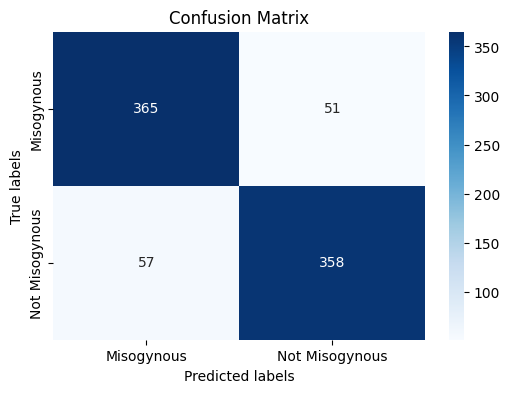

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
NEU: 4
NEG: 38
POS: 9
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 47
NEU: 7
POS: 3
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
ironic: 12
not ironic: 39
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 47
ironic: 10
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
others: 13
anger: 33
joy: 5
-----------------------------------
Emociones en Falsos Negativos:
anger: 41
others: 15
joy: 1
-----------------------------------
-----------------------------------

Análisis de NER (Named Entity Recognition):

NER en Falsos Positivos:
B-USER: 37
O: 1138
B-PER: 14
B-PROD: 6
B-LOC: 2
I-PER: 6
None: 1
I-TITLE: 1
I-PROD: 2
-----------------------------------


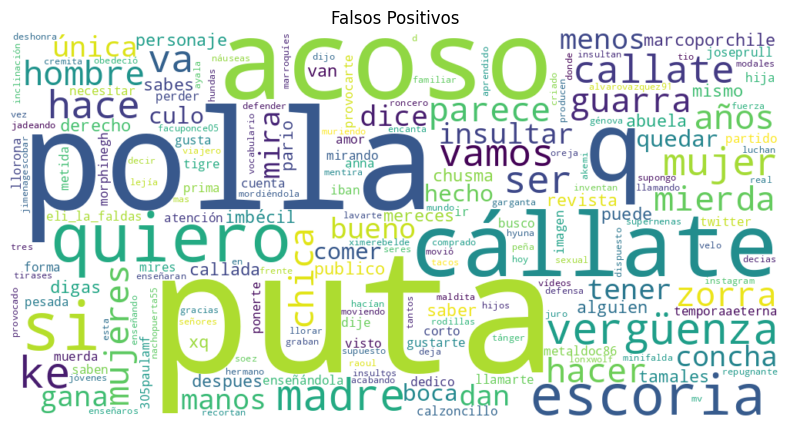

-----------------------------------
Falsos Negativos:
Las 25 palabras más comunes y su núm de apariciones:
[('puta', 39), ('cállate', 14), ('si', 11), ('q', 11), ('polla', 7), ('mierda', 7), ('enseñar', 7), ('boca', 7), ('...', 6), ('acoso', 6), ('madre', 6), ('mujer', 6), ('así', 6), ('callate', 6), ('axel', 6), ('hijo', 5), ('zorra', 5), ('voy', 5), ('escoria', 4), ('mujeres', 4), ('hacer', 4), ('hijos', 4), ('dios', 4), ('todas', 3), ('¿qué', 3)]


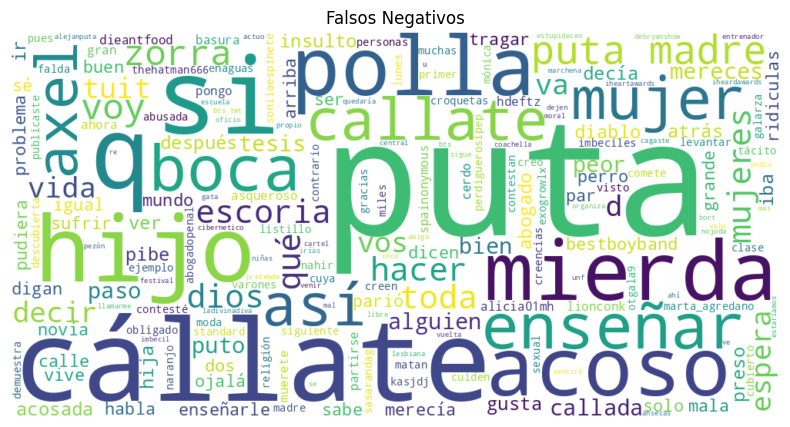

-----------------------------------
-----------------------------------

Ejemplos de Falsos Positivos:

@Eli_la_faldas Yo tengo una con forma de polla
Mi prima está esta mirando el partido y le dije q iban a perder y me dice CÁLLATE HIJA DE PUTA q amor
@metaldoc86 @TemporaAeterna No saben tener su puta polla de muerda metida en el calzoncillo y necesitar ir enseñándola.
@joseprull La imagen de la vergüenza eres tu...Tigre tu eres una puta vergüenza llorona
Anna, pesada, cállate. Bueno, mira, es mi puta cuenta de Twitter y la dedico a las putas mierdas que me dan la gana.
por qué ponerte algo corto te hace puta? no busco gustarte,llamarte la atención ni mucho menos provocarte. me visto como quiero,cuando quiero y porque quiero. no te gusta? no mires.
@305Paulamf @MorphineGH @AlvaroVazquez91 Hombre supongo que no todos!! Pero si muy guarra se inventan insultos, graban vídeos y recortan, insultan al hermano en el Instagram... Su única defensa es insultar a Raoul en vez de defender al suyo

AttributeError: 'NoneType' object has no attribute 'startswith'

In [14]:
df_test["predictions"] = df_roberta["predictions"]
model_name = "Roberta_bne (MarIA)"

texts = df_test["text"].tolist()
modelo = "PlanTL-GOB-ES/roberta-base-bne"
vocab_stats = vocab_coverage(texts, modelo)

print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")






print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text']):
    print(i)



print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")



tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Modelo: pysentimiento/robertuito-base-uncased
Tokens totales: 25876
Tokens OOV: 0
Coverage del vocabulario: 100.00%
Top 10 OOV tokens más frecuentes: []
-----------------------------------
-----------------------------------
-----------------------------------
Evaluación para Robertuito:
-----------------------------------
-----------------------------------

Métricas:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       416
           1       0.89      0.86      0.88       415

    accuracy                           0.88       831
   macro avg       0.88      0.88      0.88       831
weighted avg       0.88      0.88      0.88       831

Accuracy: 0.8773
Precision: 0.8903
Recall: 0.8602
Macro F1 Score: 0.8772


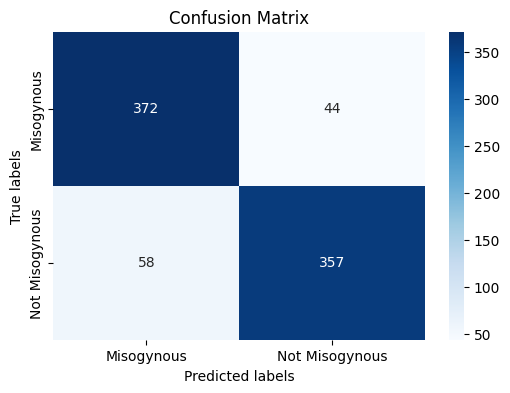

-----------------------------------
-----------------------------------

Análisis de Sentimientos:

Sentimientos en Falsos Positivos:
NEU: 6
NEG: 32
POS: 6
-----------------------------------
Sentimientos en Falsos Negativos:
NEG: 49
NEU: 7
POS: 2
-----------------------------------
-----------------------------------

Análisis de Ironia:

Ironía en Falsos Positivos:
ironic: 13
not ironic: 31
-----------------------------------
Ironía en Falsos Negativos:
not ironic: 46
ironic: 12
-----------------------------------
-----------------------------------

Análisis de Emocion:

Emociones en Falsos Positivos:
others: 12
anger: 29
joy: 3
-----------------------------------
Emociones en Falsos Negativos:
anger: 39
others: 19
-----------------------------------
-----------------------------------

Análisis de POS (Parts of Speech):

POS en Falsos Positivos:
USER: 33
PRON: 82
VERB: 170
DET: 106
ADP: 104
NOUN: 208
CONJ: 28
SCONJ: 36
AUX: 15
ADV: 38
ADJ: 68
PUNCT: 138
INTJ: 22
PROPN: 2
PART: 3
NU

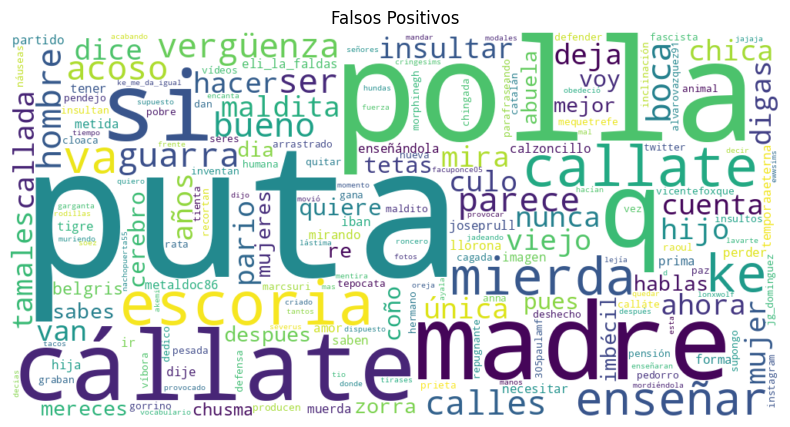

-----------------------------------
Falsos Negativos:
Las 25 palabras más comunes y su núm de apariciones:
[('puta', 32), ('cállate', 13), ('acoso', 10), ('si', 9), ('mierda', 9), ('...', 8), ('q', 8), ('zorra', 8), ('polla', 7), ('mujeres', 6), ('mujer', 6), ('callate', 6), ('axel', 6), ('madre', 5), ('enseñar', 5), ('hijo', 4), ('novia', 4), ('deja', 4), ('así', 4), ('boca', 4), ('voy', 4), ('escoria', 3), ('¿qué', 3), ('1', 3), ('día', 3)]


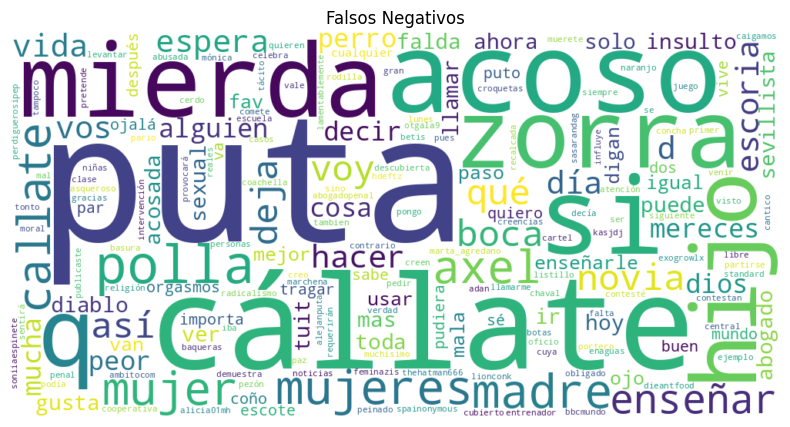

-----------------------------------
-----------------------------------

Ejemplos de Falsos Positivos:

@Eli_la_faldas Yo tengo una con forma de polla
Mi prima está esta mirando el partido y le dije q iban a perder y me dice CÁLLATE HIJA DE PUTA q amor
@metaldoc86 @TemporaAeterna No saben tener su puta polla de muerda metida en el calzoncillo y necesitar ir enseñándola.
@joseprull La imagen de la vergüenza eres tu...Tigre tu eres una puta vergüenza llorona
@VicenteFoxQue Ahora si que parafraseando, ya callate maldito animal, pendejo, viejo hijo de puta, arrastrado, viejo pedorro, mequetrefe, gorrino, cagada, víbora prieta, tepocata, y de nueva cuenta, TU CHINGADA MADRE ESCORIA, SE TE VA A QUITAR LA PENSIÓN,
Anna, pesada, cállate. Bueno, mira, es mi puta cuenta de Twitter y la dedico a las putas mierdas que me dan la gana.
@MarcSuRI @jg_dominguez Calláte tú,fascista catalán de mierda,escoria humana,deshecho de tienta,rata de cloaca....y deja a tu madre en paz, la pobre....
@305Paulamf @

In [15]:
df_test["predictions"] = df_robertuito["predictions"]
model_name = "Robertuito"

texts = df_test["text"].tolist()
modelo = "pysentimiento/robertuito-base-uncased"
vocab_stats = vocab_coverage(texts, modelo)

print("-----------------------------------")
print("-----------------------------------")
print("-----------------------------------")

print(f"Evaluación para {model_name}:")

print("-----------------------------------")
print("-----------------------------------")
print("\nMétricas:\n")
metrics = evaluate_model(df_test)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1_score_macro']:.4f}")
plot_confusion_matrix(metrics['confusion_matrix'], model_name)


print("-----------------------------------")
print("-----------------------------------")
print("\nAnálisis de Sentimientos:\n")
sentiment_count = error_analysis_sentiment(df_test)
print("Sentimientos en Falsos Positivos:")
for sentiment, count in sentiment_count['FP'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("Sentimientos en Falsos Negativos:")
for sentiment, count in sentiment_count['FN'].items():
    print(f"{sentiment}: {count}")
print("-----------------------------------")
print("-----------------------------------")


print("\nAnálisis de Ironia:\n")
irony_count = error_analysis_irony(df_test)
print("Ironía en Falsos Positivos:")
for irony, count in irony_count['FP'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("Ironía en Falsos Negativos:")
for irony, count in irony_count['FN'].items():
    print(f"{irony}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de Emocion:\n")
emotion_count = error_analysis_emotion(df_test)
print("Emociones en Falsos Positivos:")
for emotion, count in emotion_count['FP'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("Emociones en Falsos Negativos:")
for emotion, count in emotion_count['FN'].items():
    print(f"{emotion}: {count}")
print("-----------------------------------")
print("-----------------------------------")




print("\nAnálisis de POS (Parts of Speech):\n")
pos_count = error_analysis_pos(df_test)
print("POS en Falsos Positivos:")
for pos, count in pos_count['FP'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("POS en Falsos Negativos:")
for pos, count in pos_count['FN'].items():
    print(f"{pos}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nAnálisis de NER (Named Entity Recognition):\n")
ner_count = error_analysis_ner(df_test)
print("NER en Falsos Positivos:")
for ner, count in ner_count['FP'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("NER en Falsos Negativos:")
for ner, count in ner_count['FN'].items():
    print(f"{ner}: {count}")
print("-----------------------------------")
print("-----------------------------------")



print("\nPalabras mas comunes y Wordcloud:\n")
print("Falsos Positivos:")
plot_wordcloud(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text'], 'Falsos Positivos')
print("-----------------------------------")
print("Falsos Negativos:")
plot_wordcloud(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text'], 'Falsos Negativos')
print("-----------------------------------")
print("-----------------------------------")




print("\nEjemplos de Falsos Positivos:\n")
for i in list(df_test[(df_test['predictions'] == 1) & (df_test['misogynous'] == 0)]['text']):
      print(i)
print("\n-----------------------------------")
print("\nEjemplos de Falsos Negativos:")
for i in list(df_test[(df_test['predictions'] == 0) & (df_test['misogynous'] == 1)]['text']):
    print(i)





In [16]:
results_summary = []

modelos = {
    "Few-Shot": df_few_shot["predictions"],
    "Robertuito": df_robertuito["predictions"],
    "Roberta_bne": df_roberta["predictions"],
}

y_true = df_test["misogynous"]

for nombre_modelo, y_pred in modelos.items():
    errores = (y_true != y_pred).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()

    fp_pct = 100 * fp / errores if errores > 0 else 0
    fn_pct = 100 * fn / errores if errores > 0 else 0

    results_summary.append({
        "Model": nombre_modelo,
        "Total Errors": errores,
        "FP (Count)": fp,
        "FP (%)": f"{fp_pct:.2f}%",
        "FN (Count)": fn,
        "FN (%)": f"{fn_pct:.2f}%"
    })

summary_df = pd.DataFrame(results_summary)

import pandas as pd
from tabulate import tabulate

print("\nTabla resumen de errores por modelo:\n")
print(tabulate(summary_df, headers='keys', tablefmt='github'))

summary_df.to_csv("summary_errors.csv", index=False)



Tabla resumen de errores por modelo:

|    | Model       |   Total Errors |   FP (Count) | FP (%)   |   FN (Count) | FN (%)   |
|----|-------------|----------------|--------------|----------|--------------|----------|
|  0 | Few-Shot    |             92 |           44 | 47.83%   |           48 | 52.17%   |
|  1 | Robertuito  |            102 |           44 | 43.14%   |           58 | 56.86%   |
|  2 | Roberta_bne |            108 |           51 | 47.22%   |           57 | 52.78%   |


In [17]:
y_pred_fs = df_few_shot["predictions"]
y_pred_rb = df_robertuito["predictions"]
y_pred_ro = df_roberta["predictions"]

y_true = df_test["misogynous"]

errors_fs = y_pred_fs != y_true
errors_rb = y_pred_rb != y_true
errors_ro = y_pred_ro != y_true

common_errors = errors_fs & errors_rb & errors_ro
num_common_errors = common_errors.sum()

fp_common = ((y_pred_fs == 1) & (y_true == 0) & common_errors).sum()
fn_common = ((y_pred_fs == 0) & (y_true == 1) & common_errors).sum()

fp_common_pct = 100 * fp_common / num_common_errors if num_common_errors > 0 else 0
fn_common_pct = 100 * fn_common / num_common_errors if num_common_errors > 0 else 0

results_summary.append({
    "Model": "All (in common)",
    "Total Errors": num_common_errors,
    "FP (Count)": fp_common,
    "FP (%)": f"{fp_common_pct:.2f}%",
    "FN (Count)": fn_common,
    "FN (%)": f"{fn_common_pct:.2f}%"
})

summary_df = pd.DataFrame(results_summary)
print("\nTabla con errores comunes:\n")
print(tabulate(summary_df, headers="keys", tablefmt="github"))



Tabla con errores comunes:

|    | Model           |   Total Errors |   FP (Count) | FP (%)   |   FN (Count) | FN (%)   |
|----|-----------------|----------------|--------------|----------|--------------|----------|
|  0 | Few-Shot        |             92 |           44 | 47.83%   |           48 | 52.17%   |
|  1 | Robertuito      |            102 |           44 | 43.14%   |           58 | 56.86%   |
|  2 | Roberta_bne     |            108 |           51 | 47.22%   |           57 | 52.78%   |
|  3 | All (in common) |             33 |           13 | 39.39%   |           20 | 60.61%   |
